In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("./data/SydneyHousePrices.csv")
data.head()

,Date,Id,suburb,postalCode,sellPrice,bed,bath,car,propType
0,2019-06-19,1,Avalon Beach,2107,1210000,4.0,2,2.0,house
1,2019-06-13,2,Avalon Beach,2107,2250000,4.0,3,4.0,house
2,2019-06-07,3,Whale Beach,2107,2920000,3.0,3,2.0,house
3,2019-05-28,4,Avalon Beach,2107,1530000,3.0,1,2.0,house
4,2019-05-22,5,Whale Beach,2107,8000000,5.0,4,4.0,house


## Part 1: Data Cleaning and Analysis

In [3]:
data.shape

(199504, 9)

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.head(10)

,Date,Id,suburb,postalCode,sellPrice,bed,bath,car,propType
0,2019-06-19,1,Avalon Beach,2107,1210000,4.0,2,2.0,house
1,2019-06-13,2,Avalon Beach,2107,2250000,4.0,3,4.0,house
2,2019-06-07,3,Whale Beach,2107,2920000,3.0,3,2.0,house
3,2019-05-28,4,Avalon Beach,2107,1530000,3.0,1,2.0,house
4,2019-05-22,5,Whale Beach,2107,8000000,5.0,4,4.0,house
5,2019-05-10,6,Bilgola Plateau,2107,1610000,4.0,2,2.0,house
6,2019-04-13,7,Avalon Beach,2107,1510000,3.0,1,2.0,house
7,2019-04-11,8,Avalon Beach,2107,1500000,5.0,4,4.0,house
8,2019-04-11,9,Avalon Beach,2107,1400000,3.0,1,2.0,house
9,2019-04-09,10,Avalon Beach,2107,1210000,3.0,2,2.0,house


### First, let's examine the suburb and PropType Feature

In [5]:
data.groupby('suburb')['suburb'].agg("count").sort_values(ascending = False)

suburb
Castle Hill           1250
Strathfield           1248
Ermington             1248
Carlingford           1247
Auburn                1244
                      ... 
Nattai                   1
Marrickville Metro       1
Haymarket                1
Clarendon                1
Paradise Point           1
Name: suburb, Length: 685, dtype: int64

In [6]:
data.groupby('propType')['propType'].agg('count').sort_values(ascending = False)

propType
house                   170117
townhouse                15177
duplex/semi-detached      6722
villa                     5701
terrace                   1344
other                      392
warehouse                   40
acreage                     11
Name: propType, dtype: int64

### As we can see, it seems that most of the properties sold during the last 20 years in Sydney are by far Houses, followed by Townhouses.    
### Also, the most popular suburbs are Castle Hill, Strathfield and Ermington, closely followed by Carlingford and Auburn.     
### Now let's drop features which won't be useful or redundant

In [7]:
house_price = data.drop(['Id', 'postalCode'], axis = 'columns')
house_price.head(10)

,Date,suburb,sellPrice,bed,bath,car,propType
0,2019-06-19,Avalon Beach,1210000,4.0,2,2.0,house
1,2019-06-13,Avalon Beach,2250000,4.0,3,4.0,house
2,2019-06-07,Whale Beach,2920000,3.0,3,2.0,house
3,2019-05-28,Avalon Beach,1530000,3.0,1,2.0,house
4,2019-05-22,Whale Beach,8000000,5.0,4,4.0,house
5,2019-05-10,Bilgola Plateau,1610000,4.0,2,2.0,house
6,2019-04-13,Avalon Beach,1510000,3.0,1,2.0,house
7,2019-04-11,Avalon Beach,1500000,5.0,4,4.0,house
8,2019-04-11,Avalon Beach,1400000,3.0,1,2.0,house
9,2019-04-09,Avalon Beach,1210000,3.0,2,2.0,house


In [8]:
house_price.isnull().sum()

Date             0
suburb           0
sellPrice        0
bed            154
bath             0
car          18151
propType         0
dtype: int64

We can infer here that the nulls in the car columns mean that the property does not come with a garage, and that the null in the bed column means that this is either a warehouse or acreage; so we are going to keep these values as they won't affect the analysis

### Before moving on to the outlier removal part, let's split the date column in Year, Month, Day. Doing it this way will allow us later to do some efficient grouping.


In [9]:
house_price['Year'] = house_price['Date'].dt.year
house_price['Month'] = house_price['Date'].dt.month
house_price = house_price.drop(['Date'], axis = 'columns')

In [10]:
house_price.head()

,suburb,sellPrice,bed,bath,car,propType,Year,Month
0,Avalon Beach,1210000,4.0,2,2.0,house,2019,6
1,Avalon Beach,2250000,4.0,3,4.0,house,2019,6
2,Whale Beach,2920000,3.0,3,2.0,house,2019,6
3,Avalon Beach,1530000,3.0,1,2.0,house,2019,5
4,Whale Beach,8000000,5.0,4,4.0,house,2019,5


### Finally, let's reorder the columns for better readability

In [11]:
house_price = house_price[['Year', 'Month', 'suburb', 'propType', 'sellPrice', 'bed', 'bath', 'car' ]]

In [12]:
house_price.head(10)

,Year,Month,suburb,propType,sellPrice,bed,bath,car
0,2019,6,Avalon Beach,house,1210000,4.0,2,2.0
1,2019,6,Avalon Beach,house,2250000,4.0,3,4.0
2,2019,6,Whale Beach,house,2920000,3.0,3,2.0
3,2019,5,Avalon Beach,house,1530000,3.0,1,2.0
4,2019,5,Whale Beach,house,8000000,5.0,4,4.0
5,2019,5,Bilgola Plateau,house,1610000,4.0,2,2.0
6,2019,4,Avalon Beach,house,1510000,3.0,1,2.0
7,2019,4,Avalon Beach,house,1500000,5.0,4,4.0
8,2019,4,Avalon Beach,house,1400000,3.0,1,2.0
9,2019,4,Avalon Beach,house,1210000,3.0,2,2.0


### Outlier analysis and removal

#### Now that we've made sure that our dataset is cleaned up, it's time to remove outliers which may skew our results

#### Let's start with the bed column first.  

In [13]:
house_price['bed'].unique()

array([ 4.,  3.,  5.,  6.,  2.,  7.,  8.,  1., nan, 10.,  9., 12., 15.,
       19., 26., 20., 14., 24., 13., 30., 16., 36., 18., 23., 11., 17.,
       99., 22., 45., 21., 34.])

##### As we can see, there are some properties with 99, 45 or 36 bedrooms. This is either a human error or outliers which will skew our results, so let's analyse them and depending on the results, we will get rid of them.

In [14]:
house_price[house_price['bed'] > 30]

,Year,Month,suburb,propType,sellPrice,bed,bath,car
37025,2009,3,Neutral Bay,townhouse,6215000,36.0,24,24.0
106339,2013,2,Dangar Island,house,660000,99.0,1,4.0
170630,2013,3,Burwood,house,3640000,45.0,9,NaN
188811,2011,12,Birrong,house,445000,34.0,1,2.0


##### Since we don't have the total square footage information, we can't possibly know if this is due to human error or not.    
#### However, we can get rid of the 99, 45 and 34 beds row since we can infer that such a gigantic house would come with more bathrooms, a garage, or would ask a more expensive price.

In [15]:
house_price = house_price.drop(house_price[house_price.bed >= 30].index)

In [16]:
house_price[house_price.bed >30]

,Year,Month,suburb,propType,sellPrice,bed,bath,car


#### Now, let's do the same process for the number of bathrooms. If there are more than 30 bathrooms, we get rid of the row

In [17]:
house_price = house_price.drop(house_price[house_price.bath > 30].index)

In [18]:
house_price[house_price.bath > 30]

,Year,Month,suburb,propType,sellPrice,bed,bath,car


## Part 2: Feature Engineering and Dimensionality Reduction

### First, let's analyze how many suburbs we have

In [19]:
list_suburbs = house_price['suburb'].unique()
print(len(list_suburbs), list_suburbs[:10])

685 ['Avalon Beach' 'Whale Beach' 'Bilgola Plateau' 'Clareville'
 'Bilgola Beach' 'Blacktown' 'Marayong' 'Kings Park' 'Prospect'
 'Matraville']


#### As we can see, we have 685 different suburbs.    
#### If we were to create the dummy column by suburb, we would have 685 more columns, so we need to do some dimensionality reduction first.

In [20]:
number_by_suburb = house_price.groupby('suburb')['suburb'].agg('count').sort_values(ascending = False) #get the number of properties sold by suburb in descending order
print(number_by_suburb)

suburb
Castle Hill           1250
Strathfield           1248
Ermington             1248
Carlingford           1247
Auburn                1244
                      ... 
Nattai                   1
Marrickville Metro       1
Haymarket                1
Clarendon                1
Paradise Point           1
Name: suburb, Length: 685, dtype: int64


#### We have some suburbs which only appear once or twice, so we can group them together in order to reduce the number of dimension.    
#### Let's say that, if a suburb appears less than 10 times, we put it in a suburb named 'other'.

In [21]:
len(number_by_suburb[number_by_suburb <= 10] ) # we can get rid of 77 columns
len(number_by_suburb[number_by_suburb <= 20]) # we can get rid 108 columns

108

### Let's choose, as an arbitrary cutoff, less than 20 location. This means that on average, 1 property is sold in this suburb by year.

In [22]:
less_than_20_suburbs = number_by_suburb[number_by_suburb <= 20]
print(less_than_20_suburbs)

suburb
Lakesland             20
Lower Portland        20
Duffys Forest         20
South Turramurra      20
Elizabeth Bay         19
                      ..
Nattai                 1
Marrickville Metro     1
Haymarket              1
Clarendon              1
Paradise Point         1
Name: suburb, Length: 108, dtype: int64


In [23]:
house_price.suburb = house_price.suburb.apply(lambda x: 'other' if x in less_than_20_suburbs else x)

In [24]:
house_price.groupby('suburb')['suburb'].agg('count').sort_values(ascending = False)

suburb
Castle Hill      1250
Ermington        1248
Strathfield      1248
Carlingford      1247
Auburn           1244
                 ... 
St Leonards        22
Grose Wold         22
Luddenham          22
Port Hacking       21
Bilgola Beach      21
Name: suburb, Length: 578, dtype: int64

### Finally, let's build a new DataFrame in order to get the average selling price of each types of properties for each year, as well as another DataFrame with the average by suburb.

In [25]:
temp_df = house_price.drop(columns='Month').copy()

In [26]:
avg_year_prop = pd.DataFrame(temp_df.groupby(['Year', 'propType'])['sellPrice'].mean())
avg_year_prop.sellPrice = avg_year_prop.sellPrice.apply(lambda x: "{:f}".format(x))
avg_year_prop.sellPrice = avg_year_prop.sellPrice.apply(lambda x: round(float(x)))

In [27]:
avg_year_suburb = pd.DataFrame(temp_df.groupby(['Year', 'suburb'])['sellPrice'].mean())
avg_year_suburb.sellPrice = avg_year_suburb.sellPrice.apply(lambda x :"{:f}".format(x))
avg_year_suburb.sellPrice = avg_year_suburb.sellPrice.apply(lambda x: round(float(x)))

### Since we only have one observation for the year 2000, we can drop it without losing any meaningful insights.

In [28]:
avg_year_prop = avg_year_prop.drop([2000])
avg_year_suburb = avg_year_suburb.drop([2000])

In [29]:
popular_suburb_list = list(house_price['suburb'].value_counts()[:10].index)
popular_suburb_list

['Castle Hill',
 'Strathfield',
 'Ermington',
 'Carlingford',
 'Auburn',
 'Marrickville',
 'Cherrybrook',
 'West Pennant Hills',
 'St Ives',
 'Macquarie Fields']

In [30]:
house_filt = ['house']

only_house = house_price[house_price.propType.isin(house_filt)].copy()
house_price_popular_suburb = only_house[only_house.suburb.isin(popular_suburb_list)].copy()

house_price_popular_suburb.bed = house_price_popular_suburb.bed.apply(lambda x: float(x))
house_price_popular_suburb.bath = house_price_popular_suburb.bath.apply(lambda x: float(x))
house_price_popular_suburb.sellPrice = house_price_popular_suburb.sellPrice.apply(lambda x: float(x))

## Part 3: Visualizing our data

In [31]:
sns.set_theme(style = 'darkgrid')

Text(0.5, 1.0, 'Evolution of the price of each type of property')

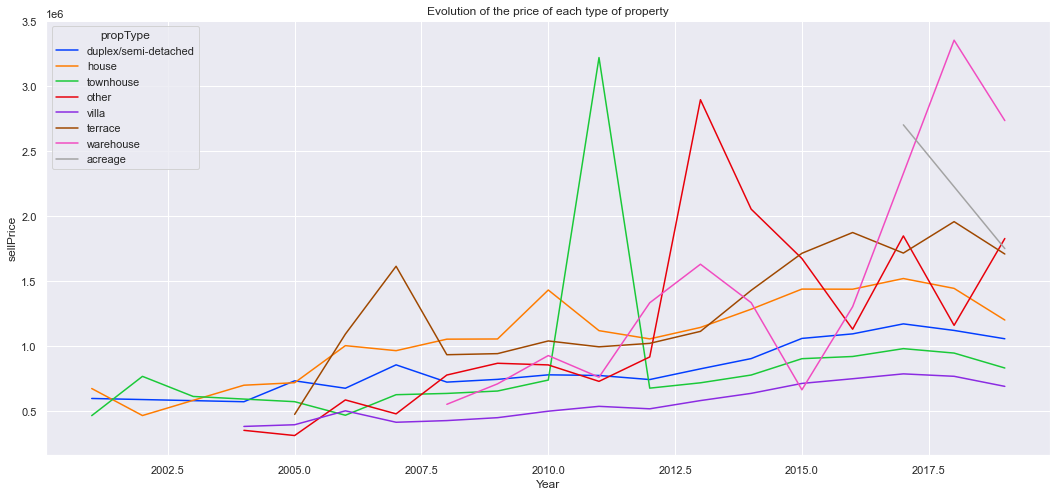

In [32]:
plt.figure(figsize= (18,8))
sns.lineplot(x = 'Year', y = 'sellPrice',
             hue = 'propType', data = avg_year_prop,
             palette = 'bright').set_title("Evolution of the price of each type of property")

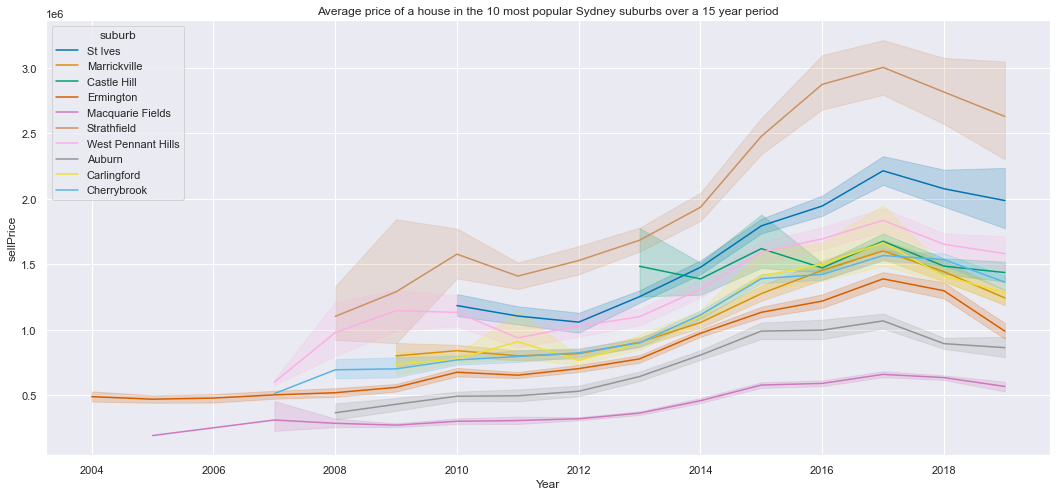

In [33]:
plt.figure(figsize=(18,8))
fig = sns.lineplot(x = 'Year', y ='sellPrice', 
             hue = 'suburb', data = house_price_popular_suburb,
             palette = 'colorblind').set_title('Average price of a house in the 10 most popular Sydney suburbs over a 15 year period')

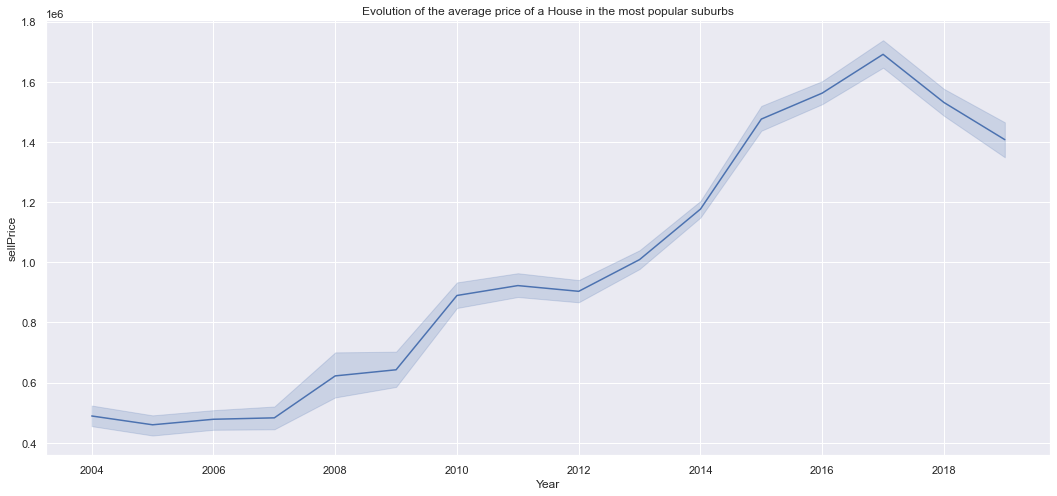

In [34]:
plt.figure(figsize = (18,8))
g = sns.lineplot(x = 'Year', y = 'sellPrice',
             data = house_price_popular_suburb, palette = 'bright').set_title('Evolution of the average price of a House in the most popular suburbs')

<AxesSubplot:xlabel='Year', ylabel='sellPrice'>

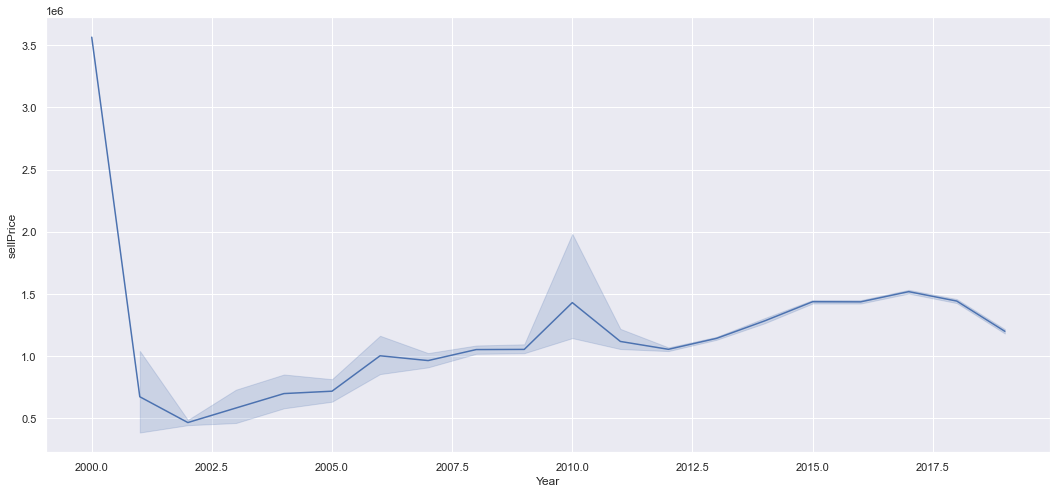

In [35]:
plt.figure(figsize = (18,8))
sns.lineplot(x = 'Year', y = 'sellPrice',
            data = only_house, palette='bright')

Text(0.5, 1.0, 'The most popular type of property')

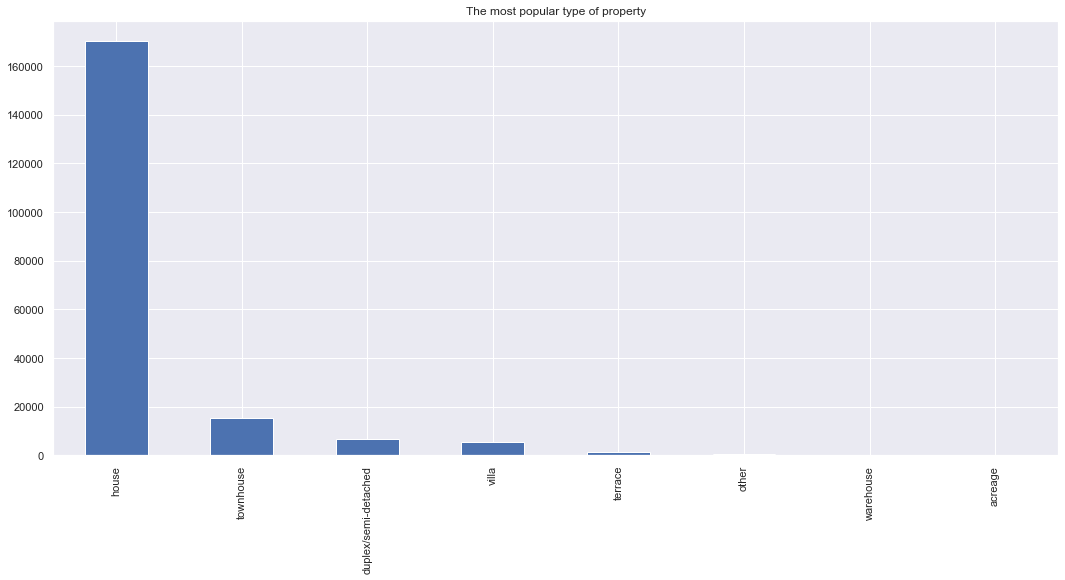

In [36]:
plt.figure(figsize= (18,8))
house_price['propType'].value_counts().plot.bar().set_title("The most popular type of property")

Text(0.5, 1.0, 'The 20 most popular suburbs in Sydney')

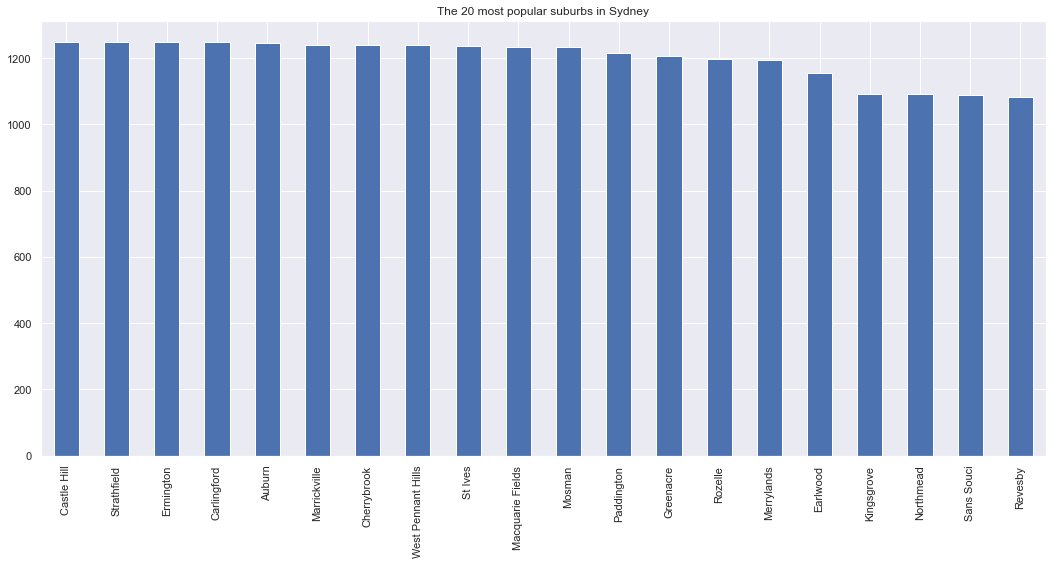

In [37]:
plt.figure(figsize = (18,8))
house_price['suburb'].value_counts()[:20].plot.bar().set_title("The 20 most popular suburbs in Sydney")

C:\Users\alexa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of houses sold each year')

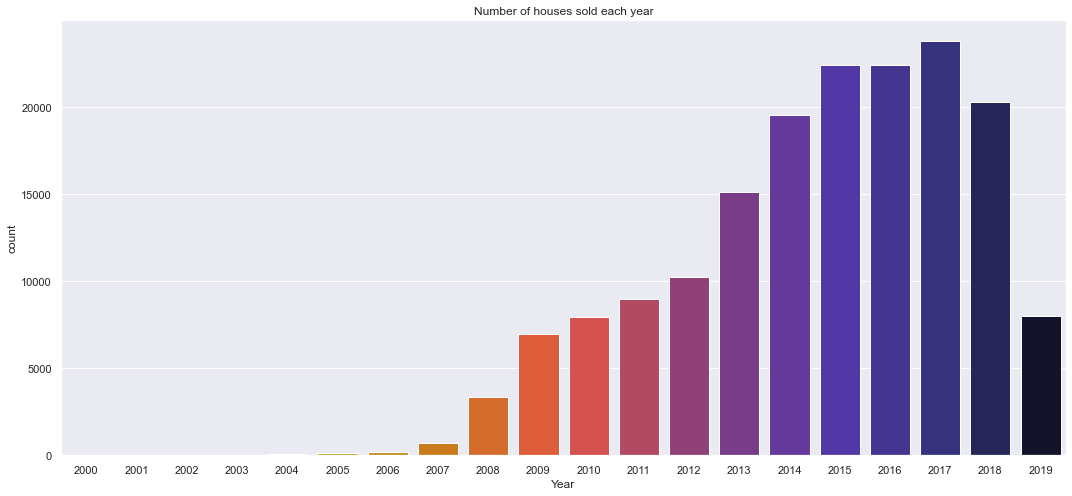

In [38]:
plt.figure(figsize = (18,8))
sns.countplot(only_house['Year'], palette = 'CMRmap_r').set_title('Number of houses sold each year')

Text(0, 0.5, 'Number of houses')

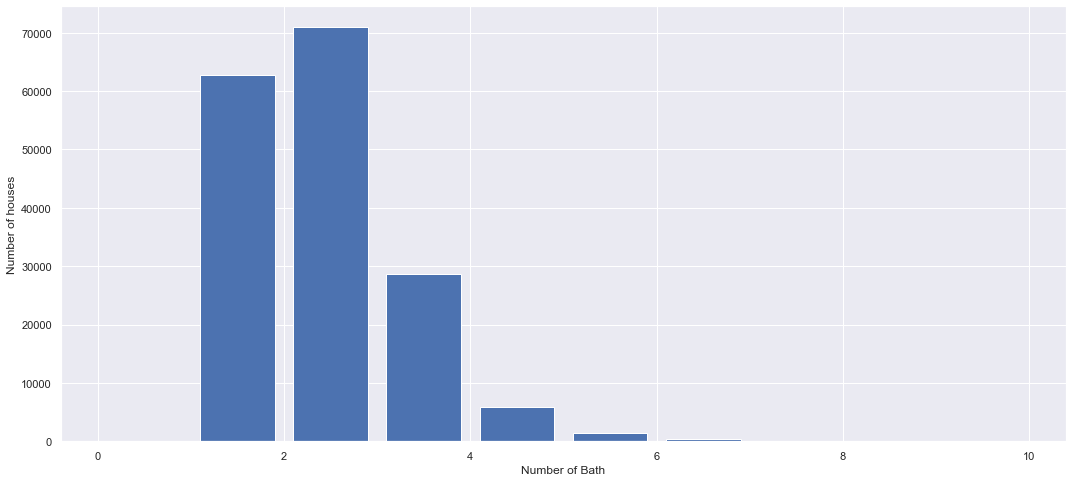

In [39]:
plt.figure(figsize = (18,8))
plt.hist(only_house.bath, rwidth = 0.8, bins = [0,1,2,3,4,5,6,7,8,9,10])
plt.xlabel('Number of Bath')
plt.ylabel('Number of houses')

Text(0, 0.5, 'Number of houses')

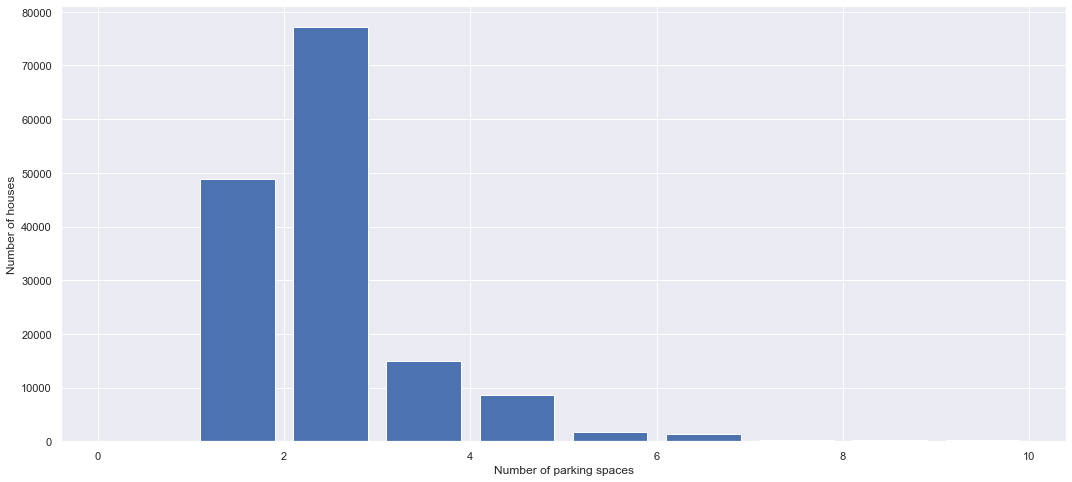

In [40]:
plt.figure(figsize=(18,8))
plt.hist(only_house.car, rwidth = 0.8, bins = [0,1,2,3,4,5,6,7,8,9,10])
plt.xlabel('Number of parking spaces')
plt.ylabel('Number of houses')

Text(0, 0.5, 'Number of Houses')

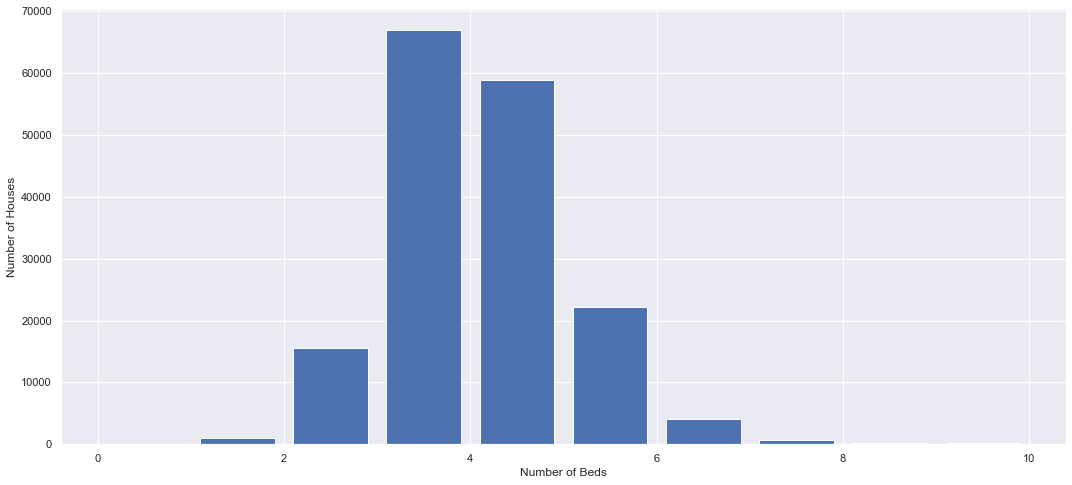

In [41]:
plt.figure(figsize=(18,8))
plt.hist(only_house.bed, rwidth = 0.8, bins = [0,1,2,3,4,5,6,7,8,9,10])
plt.xlabel('Number of Beds')
plt.ylabel("Number of Houses")

<AxesSubplot:>

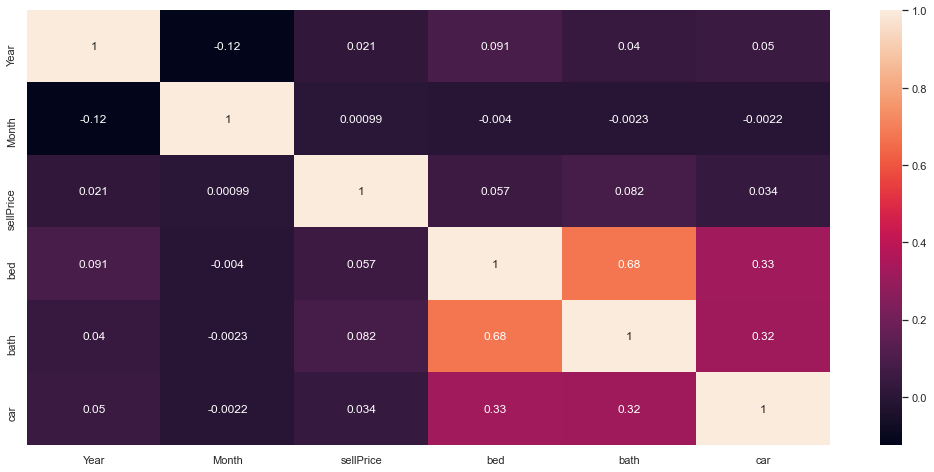

In [42]:
plt.figure(figsize = (18,8))
sns.heatmap(only_house.corr(), xticklabels = house_price.corr().columns, yticklabels = house_price.corr().columns,annot=True)

## Part 4: Dummies and Filling missing values

###  let's visualize and fill in our missing values

<AxesSubplot:>

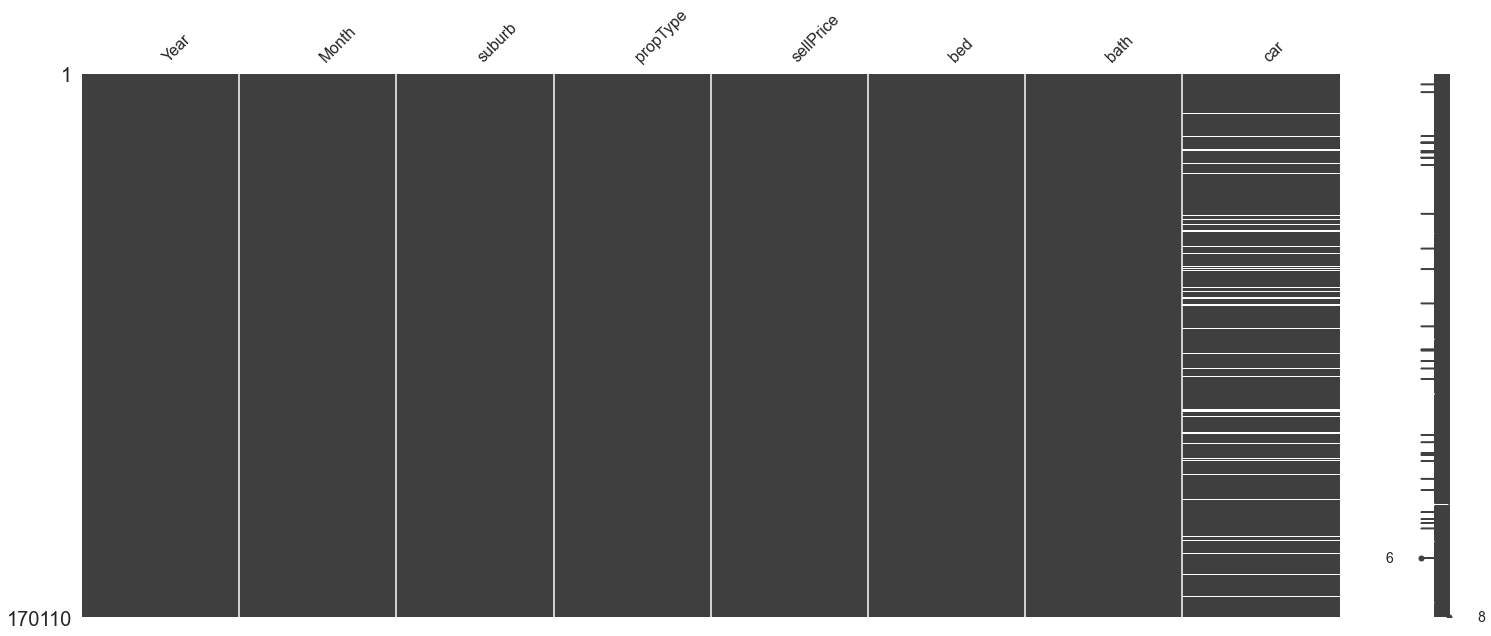

In [43]:
import missingno as msno
msno.matrix(only_house)

In [44]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer()

In [45]:
only_house['bed'] = knn_imputer.fit_transform(only_house[['bed']])
only_house['car'] = knn_imputer.fit_transform(only_house[['car']])

<AxesSubplot:>

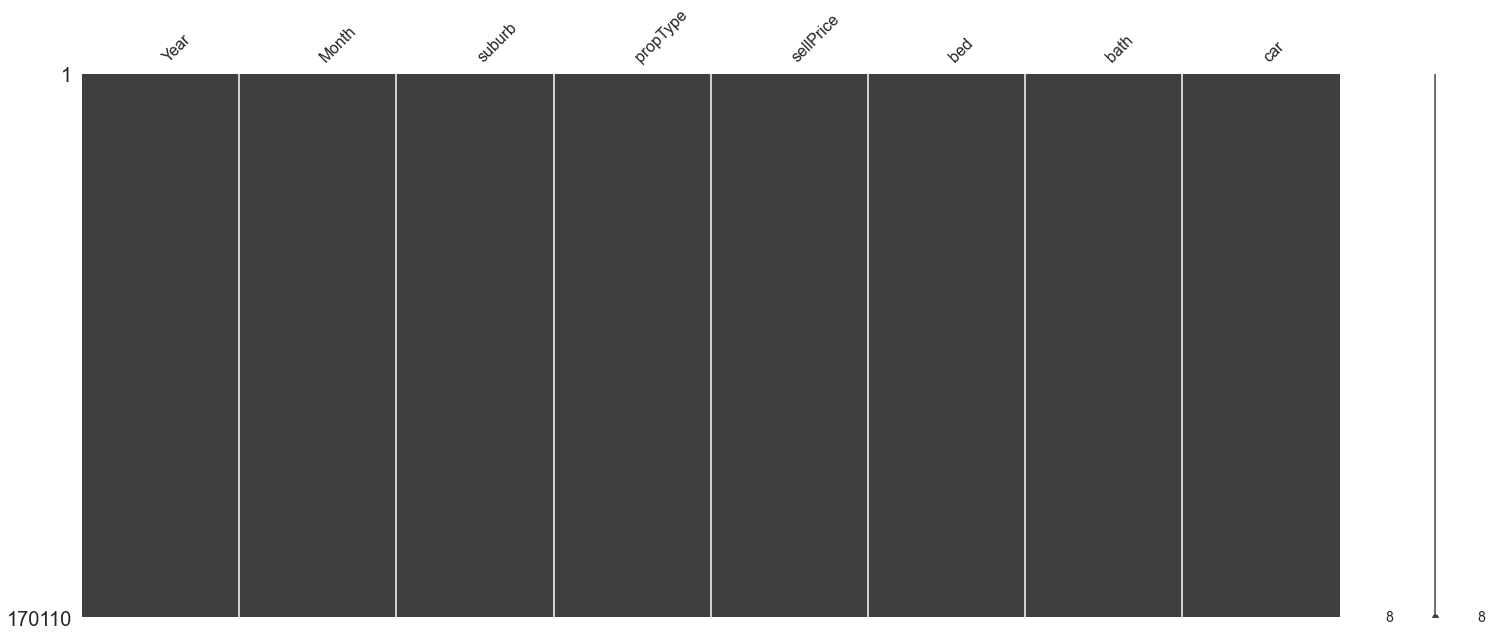

In [46]:
msno.matrix(only_house)

### Since we use KNN imputer, we now have decimal values in our columns, so let's round them

In [47]:
only_house.bed = only_house.bed.apply(lambda x: round(x))
only_house.car = only_house.car.apply(lambda x: round(x))
only_house.bath = only_house.bath.apply(lambda x: round(x))

### In order to make more accurate prediction, we are going to only keep the last two years and the 100 most popular suburbs

In [48]:
years = [2019,2018]
hundred_popular_suburbs = list(house_price.suburb.value_counts()[:100].index)
only_house_two_years = only_house[only_house.Year.isin(years)].copy()
only_house_two_years = only_house_two_years[only_house_two_years.suburb.isin(hundred_popular_suburbs)].copy()
only_house_two_years

,Year,Month,suburb,propType,sellPrice,bed,bath,car
0,2019,6,Avalon Beach,house,1210000,4,2,2
1,2019,6,Avalon Beach,house,2250000,4,3,4
3,2019,5,Avalon Beach,house,1530000,3,1,2
6,2019,4,Avalon Beach,house,1510000,3,1,2
7,2019,4,Avalon Beach,house,1500000,5,4,4
...,...,...,...,...,...,...,...,...
197900,2018,10,other,house,1445000,3,1,4
197967,2018,8,other,house,1640000,4,2,2
198020,2018,7,other,house,531000,3,1,1
198076,2018,5,other,house,583000,4,2,1


### Then, we need to get the dummies of the suburbs and propType

In [49]:
dummies_suburb = pd.get_dummies(only_house_two_years['suburb'])
dummies_propType = pd.get_dummies(only_house_two_years['propType'])

In [50]:
model_df = pd.concat([only_house_two_years, dummies_suburb, dummies_propType], axis = 'columns') # We can drop a column, if every other column is 0, then we know that this must be a 'other' suburb
model_df = model_df.drop(['suburb', 'propType', 'house', 'Month', 'Year'], axis = 'columns') 

In [51]:
model_df.sellPrice = model_df.sellPrice.apply(lambda x: x/1000000)
model_df

,sellPrice,bed,bath,car,Alexandria,Annandale,Ashfield,Auburn,Avalon Beach,Balmain,...,Turramurra,Vaucluse,Wahroonga,Warriewood,West Pennant Hills,West Ryde,Willoughby,Woollahra,Yagoona,other
0,1.210,4,2,2,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2.250,4,3,4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1.530,3,1,2,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,1.510,3,1,2,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,1.500,5,4,4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197900,1.445,3,1,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
197967,1.640,4,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
198020,0.531,3,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
198076,0.583,4,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Part 5: Model Building and Hyperparameter Tuning

### In order to build our model, we are going to split our data and put the dependent variable, i.e the "sellPrice" column, into another variable. 

In [52]:
X = model_df.drop(['sellPrice'], axis = 'columns') 
X.head()

,bed,bath,car,Alexandria,Annandale,Ashfield,Auburn,Avalon Beach,Balmain,Bass Hill,...,Turramurra,Vaucluse,Wahroonga,Warriewood,West Pennant Hills,West Ryde,Willoughby,Woollahra,Yagoona,other
0,4,2,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,3,4,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,3,1,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,5,4,4,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
y = model_df['sellPrice']
y.head()

0    1.21
1    2.25
3    1.53
6    1.51
7    1.50
Name: sellPrice, dtype: float64

### Now, let's divide our dataset into a Training and Testing split and see which model perform the best


In [54]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [56]:
def get_best_model(X, y):
    '''
    Helper function that will give us the best model as well as its R-square score. 
    We will use the Default parameters for all the functions.
    input: X, y
    output: a data frame with the models and their results
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    models = {
        'linear_regression':{
            'model': LinearRegression(),
            'params': {
                'normalize':[False]
            }
        },
        'lasso':{
            'model': Lasso(),
            'params':{
                'alpha':[1],
                'selection': ['cyclic']
            }
        },
        'decision_tree':{
            'model' : DecisionTreeRegressor(),
            'params': {
                'criterion':['squared_error'],
                'splitter':['best']
            }
        },
        'XGBRegressor':{
            'model': XGBRegressor(),
            'params':{
                'booster':['gbtree']
            }
            
        }
        
    }
    scores = []
    for model, config in models.items():
        algo = config['model']
        algo.fit(X_train, y_train)
        scores.append({
            'model':model,
            'score': round(algo.score(X_test, y_test), 3)
        })
    return pd.DataFrame(scores, columns = ['model', 'score'])

In [59]:
get_best_model(X, y)

,model,score
0,linear_regression,0.597
1,lasso,-0.000
2,decision_tree,0.595
3,XGBRegressor,0.694


### As we can see, it seems as though XGBRegressor and DecisionTreeRegressor perform better than a simple Linear Regression. Let's see if this stil holds with cross validation

In [60]:
def cross_validation(X,y):
    '''
    Helper function which will give us the cross-validation scores for each algorithm
    input: X, y
    output: A Dataframe with the name of the model as well as its score
    '''
    algos = [LinearRegression(), 
            Lasso(),
            DecisionTreeRegressor(),
            XGBRegressor()]
    scores = []
    cv = ShuffleSplit(n_splits = 5, test_size=0.2)
    for algo in algos:
        scores.append({
            'algo': algo,
            'cross_val_scores': round(np.mean(cross_val_score(algo, X,y, cv=cv)), 3)
        })
        
    return pd.DataFrame(scores, columns=['algo', 'cross_val_scores'])

In [63]:
cross_validation(X,y)

,algo,cross_val_scores
0,LinearRegression(),0.585
1,Lasso(),-0.000
2,DecisionTreeRegressor(),0.544
3,"XGBRegressor(base_score=None, booster=None, co...",0.675


In [59]:
xgb_model = XGBRegressor()

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, test_size = 0.2)

In [61]:
xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)

0.6899224205033352

In [62]:
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2)))

MSE: 0.49
RMSE: 0.70


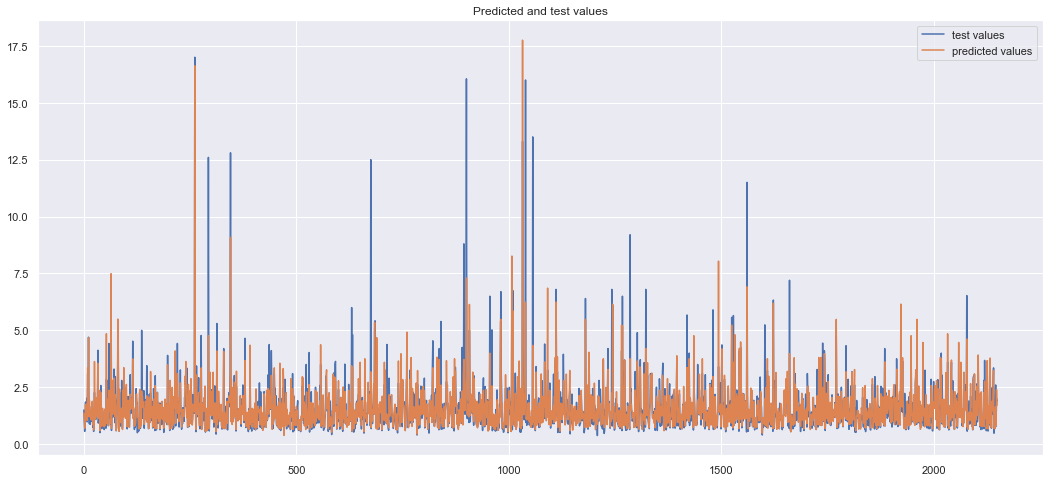

In [63]:
x_ax = range(len(y_test))
plt.figure(figsize=(18,8))
plt.plot(x_ax, y_test, label = 'test values')
plt.plot(x_ax, y_pred, label = 'predicted values')
plt.title('Predicted and test values')
plt.legend()
plt.show()

## Conclusion

### Throughout this project, we have acquired and cleaned a dataset by doing some outlier removal as well as using KNN imputer. Then, we visualized our data thanks to seaborn in order to get a better understanding of our data. Finally, we created two custom functions that gave us the best model as well as its R-squared score.    
### In conclusion, we can safely say that, in this case, the best model is not some linear Regression, but XGBRegressor.

In [64]:
import pickle
with open('sydney_price_pred_model.pickle', 'wb') as f:
    pickle.dump(xgb_model, f)

In [66]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open('columns.json','w') as f:
    f.write(json.dumps(columns))